In [ ]:
# BLOCK 1: SETUP & LOAD DATA 
import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab') 

file_path = './form_response.csv'
df = pd.read_csv(file_path)

# Target coloumn to be analyzed
target_column = '(kualitatif) Menurut Anda, apa yang paling perlu ditingkatkan agar kampus lebih toleran dan nyaman untuk semua agama?  '

# Check data
# print(f"Data berhasil di-load. Jumlah baris: {len(df)}")
# df.head(5) 
df_text = df.dropna(subset=[target_column]).copy()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [14]:
# TEXT PREPROCESSING

# 1. Setup Stopwords 
list_stopwords = set(stopwords.words('indonesian'))
kata_sampah_tambahan = {
    'dan', 'yang', 'untuk', 'di', 'ke', 'dari', 'ini', 'itu', 'atau', 'tapi',
    'juga', 'akan', 'sudah', 'saya', 'agar', 'karena', 'tentang', 'lebih',
    'pada', 'adalah', 'bisa', 'ada', 'tidak', 'memadai', 'sering', 'semua',
    'bagi', 'paling', 'perlu', 'ditingkatkan', 'kampus', 'nyaman', 'toleran',
    'mahasiswa', 'terkait', 'isu', 'hanya', 'saja', 'menurut', 'anda',
    'sangat', 'mungkin', 'seperti', 'lain', 'setiap', 'gtu', 'yg', 'ga', 'wkwk',
    'will', 'be', 'ok', 'dengan', 'dalam', 'kepada', 'banyak', 'intinya', 'kalo',
    'tidak', 'ada', 'cukup', 'ditingkatkan', 'tolong', 'bikin', 'buat'
}
stop_words_final = list_stopwords.union(kata_sampah_tambahan)

# 2. clean text
def clean_text(text):
    if not isinstance(text, str): return ""
    text = text.lower() 
    text = re.sub(f'[{re.escape(string.punctuation)}]', '', text) 
    text = re.sub(r'\d+', '', text) 
    tokens = word_tokenize(text)
    
    filtered = [w for w in tokens if w not in stop_words_final and len(w) > 3]
    return ' '.join(filtered)

df_text['cleaned_text'] = df_text[target_column].apply(clean_text)

print("Preprocessing done")


Preprocessing done


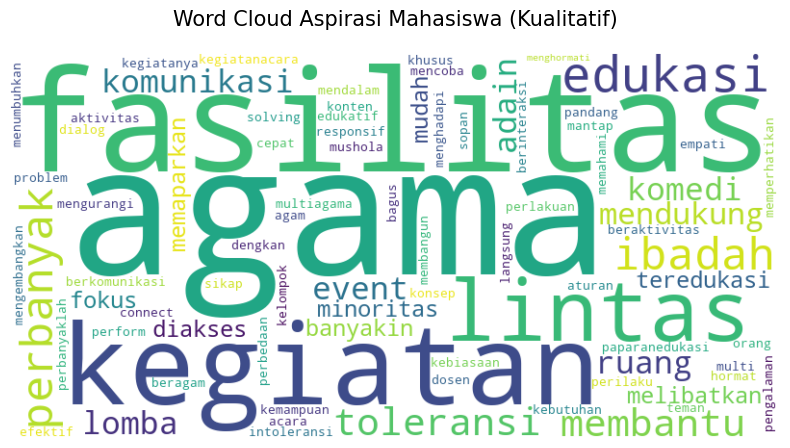

In [15]:
#Generate Word Cloud

all_text = ' '.join(df_text['cleaned_text'])

# Bikin WordCloud
wordcloud = WordCloud(width=800, height=400,
                      background_color='white',
                      colormap='viridis',
                      contour_width=1,
                      contour_color='steelblue').generate(all_text)

# Tampilkan
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud Aspirasi Mahasiswa (Kualitatif)', fontsize=15, pad=20)
plt.show()

In [18]:
#LDA Topic Modeling

# 1. convert text to nums (Vectorization TF-IDF)
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2)
tfidf_matrix = tfidf_vectorizer.fit_transform(df_text['cleaned_text'])
feature_names = tfidf_vectorizer.get_feature_names_out()


num_topics = 5 
lda_model = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda_model.fit(tfidf_matrix)

print("LDA Model Train sukses")
print(f"Jumlah data yang dianalisis: {tfidf_matrix.shape[0]}")

LDA Model Train sukses
Jumlah data yang dianalisis: 55


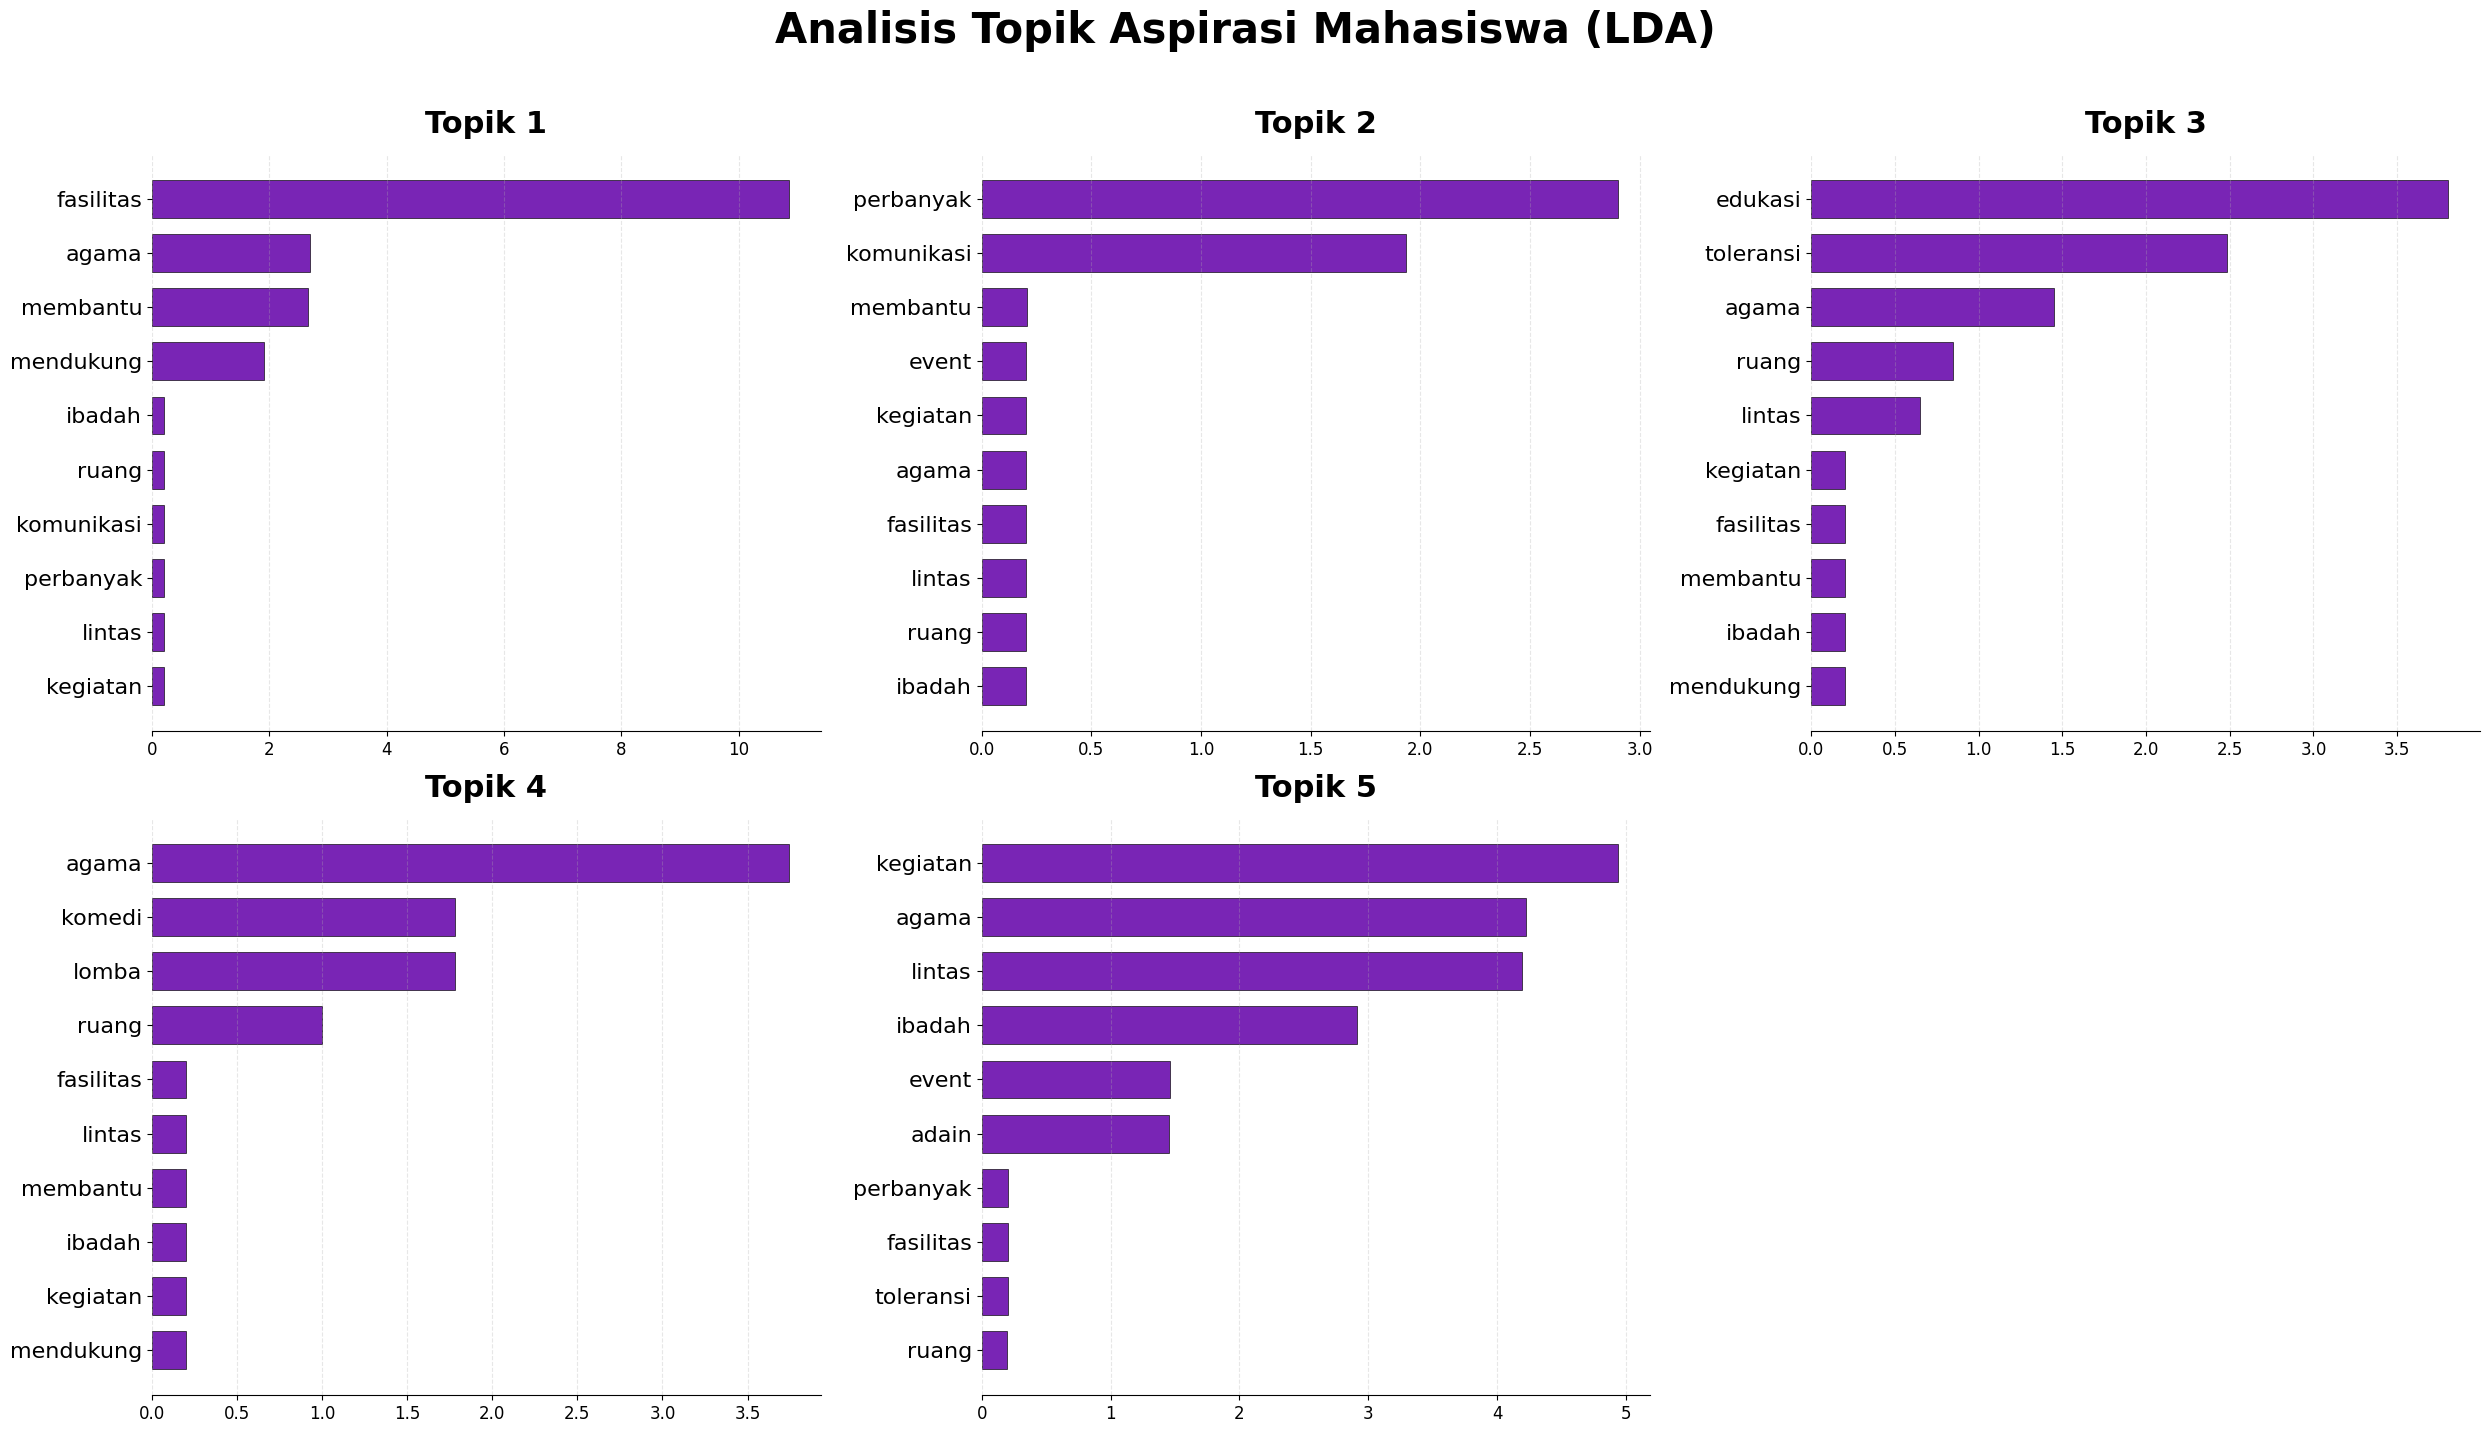

In [23]:
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 3, figsize=(25, 14), sharex=False)
    axes = axes.flatten()

    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7, color='#6a0dad', alpha=0.9, edgecolor='black', linewidth=0.5)
        
        ax.set_title(f'Topik {topic_idx +1}', fontdict={'fontsize': 22, 'fontweight': 'bold'}, pad=15)
        ax.invert_yaxis()
        
        ax.tick_params(axis='y', labelsize=16)
        ax.tick_params(axis='x', labelsize=12)
        ax.grid(axis='x', linestyle='--', alpha=0.3)

        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)

    for i in range(5, len(axes)):
        axes[i].axis('off')

    fig.suptitle(title, fontsize=30, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

plot_top_words(lda_model, feature_names, 10, 'Analisis Topik Aspirasi Mahasiswa (LDA)')